# Online Retailer: Predict Customer Lifetime Value
### This notebooks uses the dataset *OnlineRetail.xlsx*

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Objective: Predict CLV of each customer for September, October, and November of 2011.

This notebook is an example. It does not show an exhaustive detail on all CRISP-DM phases.

(c) 2020-2022 Nuno António - Rev. 1.01

### Dataset description
Public dataset available at http://archive.ics.uci.edu/ml/datasets/online+retail.<br>
The dataset is composed of the following variables:<br>
- **InvoiceNo**: Invoice number.
- **StockCode**: Item code.
- **Description**: Item description.
- **Quantity**: Quantity bought.
- **InvoiceDate**: Invoice issue date (sell date).
- **Unit price**: Unit price.
- **CustomerID**: Customer ID.
- **Country**: Customer's country of origin. 

### Initial setup and modules/packages loading

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import PredictionError

# If necessary install optuna (pip install optuna)
# For more information on Optuna (framework for automating the parameter optimization process) check https://optuna.org
import optuna

#to plot in notebook
%matplotlib inline

### Data understanding

In [2]:
# Load data (EXCEL not CSV format)
ds = pd.read_excel('OnlineRetail.xlsx', sheet_name='Online Retail',engine='openpyxl')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


There is no column with the invoice line total

In [3]:
# Display top 15 rows
ds.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
# Summary statistics for all variables
ds.describe(include='all').T

<ipython-input-4-c994b14a6a5c>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ds.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,NaT,NaT,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,NaT,NaT,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,NaT,NaT,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Summary statistis analysis:
- **CustomerID** was identified as a numerical column, but it's a categorical one
- **Quantity** and **UnitPrice** show negative minimums. Are these outliers or just incorrect values?
- **InvoiceDate** shows that data is not completed for December 2011

In [5]:
# Transform CustomerID to categorical
ds['CustomerID'] = ds['CustomerID'].astype('category')

In [6]:
# Create a column with the total per invoice line
ds['Total'] = ds['Quantity']*ds['UnitPrice']

In [7]:
# Do a new summary statistics for all variables
ds.describe(include='all').T

<ipython-input-7-8da0a7bb6e1f>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ds.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,NaT,NaT,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,NaT,NaT,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,4372,17841,7983,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,541909,38,United Kingdom,495478,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total,541909,NaN,NaN,NaN,NaT,NaT,17.9878,378.811,-168470,3.4,9.75,17.4,168470


Atention!! There are many lines without **CustomerID**

<AxesSubplot:xlabel='Country'>

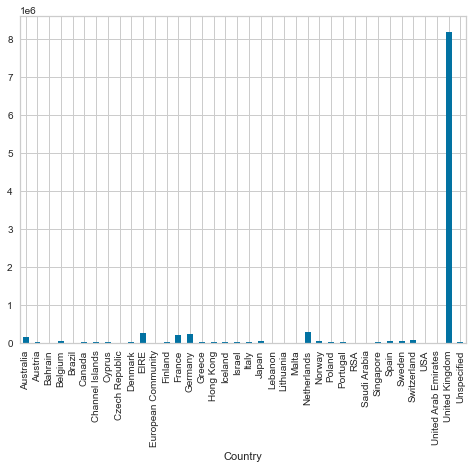

In [8]:
# Plot sales per country
fig, ax = plt.subplots(figsize=(8, 6))
ds.groupby('Country').Total.sum().plot(kind='bar', ax=ax)

In [9]:
# Calculate number of days in period
daysInPeriod = (ds.InvoiceDate.max() - ds.InvoiceDate.min()).days
daysInPeriod

373

#### Aggregate data by customer for RFM analysis (Recency, Frequency, Monetary Value)

In [10]:
# Drop columns not necessary for this exercise
ds.drop(columns=['StockCode','Description'], inplace=True)

In [11]:
# Remove incomplete month data
ds = ds[ds['InvoiceDate'] < '2011-12-01']

In [12]:
# Remove rows with negative negative quantities or price
ds = ds[(ds.Quantity>0) & (ds.UnitPrice>0)]

In [13]:
# Remove rows without CustomerID
ds = ds[pd.notnull(ds['CustomerID'])]

In [14]:
# Compute totals per customer
dateMax = ds.InvoiceDate.max()
X = ds.groupby(['CustomerID']).agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days, 
                                                    lambda date: (dateMax - date.max()).days],
                                  'InvoiceNo': lambda i: len(i.unique()),
                                  'Total': [sum, min, max]}).fillna(0)
X.columns = ['PurchaseDuration', 'Recency', 'Frequency', 'MonetaryValue', 'MinPerPurchase', 'MaxPerPurchase']

In [15]:
# Check results
X.describe()

,PurchaseDuration,Recency,Frequency,MonetaryValue,MinPerPurchase,MaxPerPurchase
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,122.975069,88.908280,4.060842,1919.765580,30.514125,144.789959
std,128.827245,98.428224,7.368396,8287.717984,1169.873897,1344.715992
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,14.000000,1.000000,291.762500,0.850000,30.600000
50%,77.500000,47.000000,2.000000,641.660000,5.040000,51.000000
75%,243.000000,140.000000,4.000000,1576.585000,9.950000,102.000000
max,364.000000,364.000000,200.000000,268478.000000,77183.600000,77183.600000


In [16]:
# Remove customer that did not make purchases
X = X[X.MonetaryValue>0]

In [17]:
# Compute global metrics
returnRate = X[X.Frequency>1].shape[0]/X.shape[0]
churnRate = 1-returnRate

# Compute customer additional measures
X['AveragePurchaseValue'] = X.MonetaryValue/X.Frequency
X['AveragePurchaseFrequency'] = X.PurchaseDuration/X.Frequency

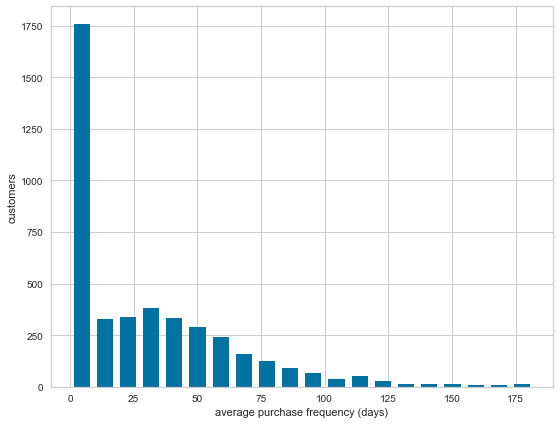

In [18]:
# Plot customers purchase frequency
ax = X['AveragePurchaseFrequency'].hist(
    bins=20,
    rwidth=0.7,
    figsize=(9,7)
)
ax.set_xlabel('average purchase frequency (days)')
ax.set_ylabel('customers')
plt.show()

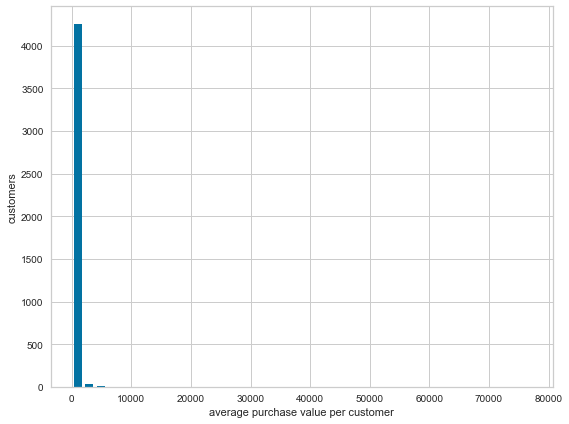

In [19]:
# Plot customers average purchase
ax = X['AveragePurchaseValue'].hist(
    bins=40,
    rwidth=0.7,
    figsize=(9,7)
)
ax.set_xlabel('average purchase value per customer')
ax.set_ylabel('customers')
plt.show()

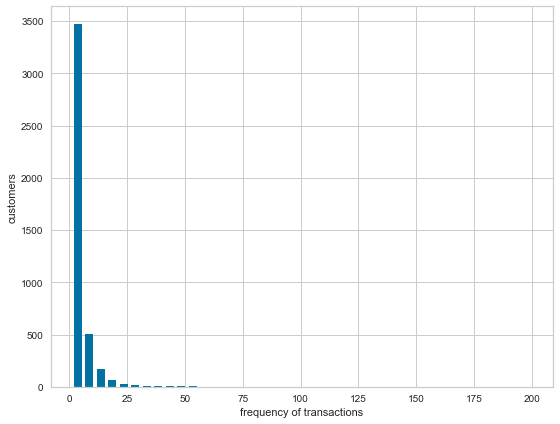

In [20]:
# Plot transactions per customer
ax = X['Frequency'].hist(
    bins=40,
    rwidth=0.7,
    figsize=(9,7)
)
ax.set_xlabel('frequency of transactions')
ax.set_ylabel('customers')
plt.show()

### Data preparation

In [21]:
# Compute RFM and other metrics for the first 9 months as the modeling dataset
dateMax = pd.to_datetime('2011-08-31')
X2 = ds[ds['InvoiceDate']<'2011-09-01'].groupby(['CustomerID']).agg(
    {'InvoiceDate': [lambda date: (date.max() - date.min()).days, 
                    lambda date: (dateMax - date.max()).days],
    'InvoiceNo': lambda i: len(i.unique()),
    'Total': [sum, min, max]}).fillna(0)
X2.columns = ['PurchaseDuration', 'Recency', 'Frequency', 'MonetaryValue', 'MinPerPurchase', 'MaxPerPurchase']

# Compute customer additional measures
X2['AveragePurchaseValue'] = X2.MonetaryValue/X2.Frequency
X2['AveragePurchaseFrequency'] = X2.PurchaseDuration/X2.Frequency

In [22]:
# Compute sales per customer last 3 months
sales = ds[ds['InvoiceDate']>'2011-08-31'].groupby(['CustomerID']).agg('Total').sum().fillna(0)
sales = sales.rename('CLV_Next3Months')

In [23]:
# Merge modeling dataset with sales following 3 months
X2 = X2.merge(sales.to_frame(), left_index=True, right_index=True).fillna(0)

In [24]:
# Remove customers who did not bought nothing in the first 9 months (new customers in the last 3 months)
X2 = X2[X2.MonetaryValue>0]

In [25]:
# Find and remove outliers

# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

# Find and remove outliers
cols = ['MonetaryValue']
X2 = removeOutliers(X2, colList=cols , lowPercentile=0.01, highPercentile=0.99, verbose=True)

      MonetaryValue
0.01        41.6160
0.99     14344.0432


### Modeling

In [26]:
# Create the Target
y = X2['CLV_Next3Months']

In [27]:
# Normalize training data
scaler = MinMaxScaler(feature_range=(0, 1))

# MinMax scaler returns an array, so the dataframe must be recreated
X2_scaled = pd.DataFrame(scaler.fit_transform(X2.values), columns=X2.columns,index=X2.index)

In [28]:
# Split the dataset intro train and test
X_train, X_test, y_train, y_test = train_test_split(X2_scaled, y, train_size = 0.75, test_size = 0.25, random_state = 123)

In [29]:
# Remove the Target from the training
X_train = X_train.drop(['CLV_Next3Months'],1)
X_test = X_test.drop(['CLV_Next3Months'],1)

In [30]:
# Use optuna to search for the best parameters
def objective(trial):
      hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes', 3, 8)
      max_iter = trial.suggest_int('max_iter', 500, 1000)
      reg = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=123)
      return cross_val_score(reg, X_train, y_train, 
           n_jobs=-1, cv=5, scoring='r2').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial
print('r2: {}'.format(trial.value))

print("Best hyperparameters: {}".format(trial.params))

[I 2022-02-24 16:37:51,701] A new study created in memory with name: no-name-0186a2e0-7edd-4beb-901b-0924cb60380b
[I 2022-02-24 16:37:54,046] Trial 0 finished with value: 0.06849474950322584 and parameters: {'hidden_layer_sizes': 5, 'max_iter': 746}. Best is trial 0 with value: 0.06849474950322584.
[I 2022-02-24 16:37:55,554] Trial 1 finished with value: -0.06427875273782421 and parameters: {'hidden_layer_sizes': 3, 'max_iter': 820}. Best is trial 0 with value: 0.06849474950322584.
[I 2022-02-24 16:37:57,275] Trial 2 finished with value: 0.11011437290382234 and parameters: {'hidden_layer_sizes': 6, 'max_iter': 932}. Best is trial 2 with value: 0.11011437290382234.
[I 2022-02-24 16:37:58,548] Trial 3 finished with value: -0.04140293880259192 and parameters: {'hidden_layer_sizes': 3, 'max_iter': 902}. Best is trial 2 with value: 0.11011437290382234.
[I 2022-02-24 16:37:59,633] Trial 4 finished with value: -0.15131169137234374 and parameters: {'hidden_layer_sizes': 3, 'max_iter': 514}. Be

r2: 0.15349879806577482
Best hyperparameters: {'hidden_layer_sizes': 7, 'max_iter': 998}


In [31]:
# Optimization history
optuna.visualization.plot_optimization_history(study)

In [32]:
# Slice by parameter
optuna.visualization.plot_slice(study)

In [33]:
# See in a parellell cordinates plot
optuna.visualization.plot_parallel_coordinate(study)

<font color='blue'>C1: Try to optimize results by experimenting with other parameters</font>

In [34]:
# Create the model
estimator = MLPRegressor(**trial.params)

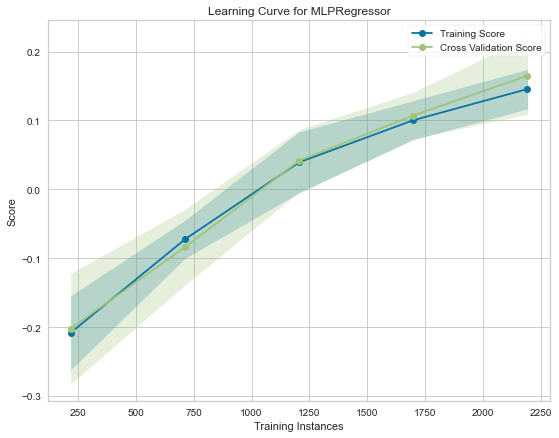

<AxesSubplot:title={'center':'Learning Curve for MLPRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [35]:
# Plot the learning curve
fig, ax = plt.subplots(figsize=(9, 7))
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=estimator, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(X_train, y_train)
visualizer.show(ax=ax)

In [36]:
# Create and train the model
estimator.fit(X_train, y_train)

/Users/nunoantonio/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (998) reached and the optimization hasn't converged yet.



MLPRegressor(hidden_layer_sizes=7, max_iter=998)

### Evaluation

In [37]:
# predict y for X_train and X_test
y_pred_train = estimator.predict(X_train) 
y_pred_test = estimator.predict(X_test) 

In [38]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest,set1='Train', set2='Test'):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, set1: train_results, set2:test_results})
  return(resultsDF)

In [39]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,5.639602e+02,5.236137e+02
1,RMSE,1.114147e+03,8.470956e+02
2,R^2,1.443278e-01,1.797080e-01
3,MAPE (%),9.352848e+17,9.776905e+17
4,MAX Error,1.804135e+04,8.570532e+03


In [40]:
# Visualize predictions vs target values 
temp = y_test.to_frame()
temp['Prediction'] = y_pred_test
temp['Residual'] = y_test - temp.Prediction
temp

,CLV_Next3Months,Prediction,Residual
CustomerID,,,
14640.0,624.02,629.604119,-5.584119
16066.0,1205.49,372.974557,832.515443
16327.0,1374.58,830.225741,544.354259
16690.0,139.08,340.045899,-200.965899
17703.0,307.78,442.041479,-134.261479
...,...,...,...
12641.0,0.00,351.761681,-351.761681
14784.0,175.31,343.767523,-168.457523
18044.0,772.17,772.760395,-0.590395


/Users/nunoantonio/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MLPRegressor was fitted with feature names



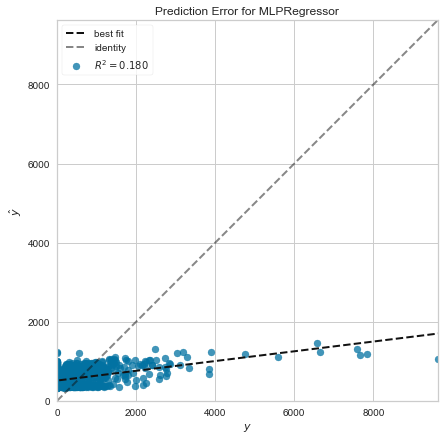

<AxesSubplot:title={'center':'Prediction Error for MLPRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [41]:
# Visualize the prediction error
fig, ax = plt.subplots(figsize=(9, 7))
predError_vis = PredictionError(estimator)
predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show(ax=ax)